# Step 4 - Comparison

This notebook evaluates the correlation between the accuracy of the blackbox and the ability for us to estimate it using a network of similar complexity.

## Imports

In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import keras.backend as K
from keras.datasets import mnist

print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.4-tf


Using TensorFlow backend.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle

import os.path
import shutil
import math
import random

In [3]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# model params (MUST MATCH Blackbox Evaluator PARAMS)
num_classes = 10
max_epochs = 25
save_every = 1
discriminator_epochs = 25

# client params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets
    
minibatch_size = None                           # number of samples to operate on at one time
                                                # - can vary to optimize computing requirements
                                                # - if None, will evaluate the client's whole batch regardless of its size
    
batches_per_train_step = 20                     # after averaging the gradients from X clients, we will apply them to the model

shuffle_clients = True

# dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model

## Load Data

In [5]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [7]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


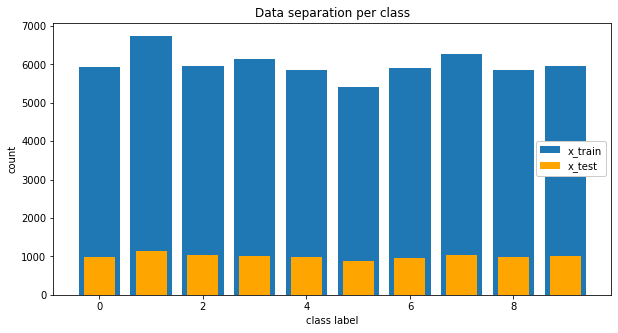

In [8]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

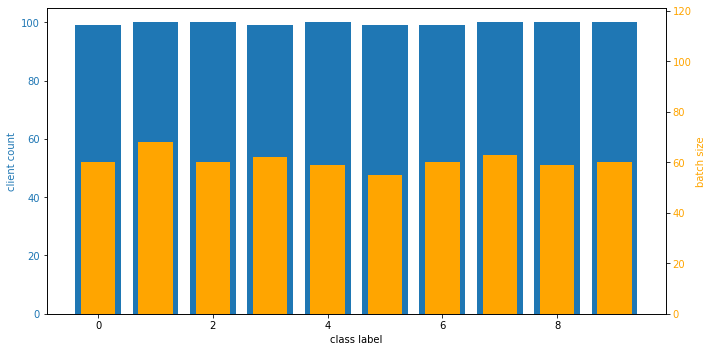

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [9]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

#### Load the y_eval sets generated by the Blackbox model

## Build Model

In [10]:
def blackbox_model(input_layer, training=True):
    h = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, trainable=training)(input_layer)
    h = Conv2D(64, (3, 3), activation='relu', trainable=training)(h)
    h = MaxPooling2D(pool_size=(2, 2), trainable=training)(h)
    h = Dropout(0.25, trainable=training)(h, training=training)
    h = Flatten(trainable=training)(h)
    h = Dense(128, activation='relu', trainable=training)(h)
    h = Dropout(0.5, trainable=training)(h, training=training)
    output_layer = Dense(num_classes, activation='softmax', trainable=training)(h)
    
    return output_layer

In [11]:
# to remove model complexity, the blackbox and discriminator models will be kept the same

def discriminator_model(input_shape, training=True):
    model = blackbox_model(input_shape, training)
    
    return model

In [12]:
input_shape = (target_rows, target_cols, 1)

## Graph Creation

In [13]:
# add nodes for input and discriminator model
x = keras.Input(shape=input_shape)
y_discriminator = discriminator_model(x, training=False)

# add node for input from evaluated model
y_blackbox = keras.Input(shape=(num_classes, ))

# we still need the true labels to measure accuracy differences
y_true = keras.Input(shape=(num_classes, ))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
# Define loss function in terms of y_pred and y_true
loss = keras.losses.MSE(y_blackbox, y_discriminator)

# Setup metrics to look at during training:
_, acc_op_b = tf.metrics.accuracy(labels=tf.argmax(y_true, 1), predictions=tf.argmax(y_blackbox, 1))
_, acc_op_d = tf.metrics.accuracy(labels=tf.argmax(y_true, 1), predictions=tf.argmax(y_discriminator, 1))

# Define extra accuracy to look at acc between both models
_, acc_op_c = tf.metrics.accuracy(labels=tf.argmax(y_blackbox, 1), predictions=tf.argmax(y_discriminator, 1))

## Optimizer definition - nothing different from any classical example
optimizer = tf.train.AdamOptimizer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver(max_to_keep=discriminator_epochs)

In [15]:
# INSPIRED by https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients

# Fetch a list of our network's trainable parameters.
trainable_vars = tf.trainable_variables()

# Create variables to store accumulated gradients
accumulators = [
    tf.Variable(
        tf.zeros_like(tv.initialized_value()),
        trainable=False
    ) for tv in trainable_vars
]

# Create a variable for counting the number of accumulations
accumulation_counter = tf.Variable(0.0, trainable=False)

# Compute gradients; grad_pairs contains (gradient, variable) pairs
grad_pairs = optimizer.compute_gradients(loss, trainable_vars)

# Create operations which add a variable's gradient to its accumulator.
accumulate_ops = [
    accumulator.assign_add(
        grad
    ) for (accumulator, (grad, var)) in zip(accumulators, grad_pairs)
]

# The final accumulation operation is to increment the counter
accumulate_ops.append(accumulation_counter.assign_add(1.0))

# Update trainable variables by applying the accumulated gradients
# divided by the counter. Note: apply_gradients takes in a list of 
# (grad, var) pairs
train_step = optimizer.apply_gradients(
    [(accumulator / accumulation_counter, var) \
        for (accumulator, (grad, var)) in zip(accumulators, grad_pairs)]
)

# Accumulators must be zeroed once the accumulated gradient is applied.
zero_ops = [
    accumulator.assign(
        tf.zeros_like(tv)
    ) for (accumulator, tv) in zip(accumulators, trainable_vars)
]

# Add one last op for zeroing the counter
zero_ops.append(accumulation_counter.assign(0.0))

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


## Split Training

In [16]:
# Initialize the session

sess = tf.Session()
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [17]:
# Evaluation

print('Evaluating the model...\n')

accs_test_b = []
accs_test_d = []
losses_test = []
accs_test_c = []

# Loop through every trained blackbox model, and train a new discriminator on it:
for blackbox_epoch in range(max_epochs):
    if (blackbox_epoch+1) % save_every == 0 or blackbox_epoch+1 == max_epochs:
        
        #######################################################################################
        
        # Load the outputs from the blackbox
        print('='*40)
        print('Loading previous blackbox_e{} evaluation'.format(blackbox_epoch+1))
        print()
        
        # load the pickle files:
        eval_folder = "./blackbox_evals/blackbox_e{}".format(blackbox_epoch+1)
        
        # load training batches
        batch_idxs = list(range(len(x_batches)))
        blackbox_train_batches = []
        for batch_idx in batch_idxs:
            eval_file = os.path.join(eval_folder, 'train_{}.pkl'.format(batch_idx))
            with open(eval_file, 'rb') as f:
                y_eval = pickle.load(f)
            blackbox_train_batches.append(y_eval)
            
        # load testing batches
        eval_file = os.path.join(eval_folder, 'test_all.pkl')
        with open(eval_file, 'rb') as f:
            y_eval = pickle.load(f)
        b_test = y_eval
        
        #######################################################################################
        
        # Load the discriminator weights:
        checkpoint_folder = "./discriminator_checkpoints/blackbox_e{}__discriminator_e{}".format(blackbox_epoch+1, 
                                                                                                 discriminator_epochs)
        discriminator_weights_path = os.path.join(checkpoint_folder, 'discriminator_checkpoint.ckpt')
        # model.load_weights(blackbox_weights_path)
        saver.restore(sess, discriminator_weights_path)
        
        # Evaluate the discriminator
        print('='*40)
        print('Evaluating blackbox_e{}__discriminator_e{}'.format(blackbox_epoch+1, discriminator_epochs))

        # Calculate test acc and loss
        acc_test_b, acc_test_d, loss_test, acc_test_c = sess.run([acc_op_b, acc_op_d, loss, acc_op_c],
                                                                 feed_dict={x: x_test, y_blackbox: b_test, y_true: y_test})
        loss_test = np.sum(loss_test)
        
        accs_test_b.append(acc_test_b)
        accs_test_d.append(acc_test_d)
        losses_test.append(loss_test)
        accs_test_c.append(acc_test_c)

        # Update progress bar
        print('Test Accuracy:  D[{:.3f}] --> B[{:.3f}] | MSE(D): {:e}'.format(acc_test_d, acc_test_b, loss_test))
        print()
    else:
        pass

Evaluating the model...

Loading previous blackbox_e1 evaluation

INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/blackbox_e1__discriminator_e25\discriminator_checkpoint.ckpt
Evaluating blackbox_e1__discriminator_e25
Test Accuracy:  D[0.969] --> B[0.967] | MSE(D): 3.684161e+00

Loading previous blackbox_e2 evaluation

INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/blackbox_e2__discriminator_e25\discriminator_checkpoint.ckpt
Evaluating blackbox_e2__discriminator_e25
Test Accuracy:  D[0.974] --> B[0.972] | MSE(D): 3.234272e+00

Loading previous blackbox_e3 evaluation

INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/blackbox_e3__discriminator_e25\discriminator_checkpoint.ckpt
Evaluating blackbox_e3__discriminator_e25
Test Accuracy:  D[0.977] --> B[0.975] | MSE(D): 3.526028e+00

Loading previous blackbox_e4 evaluation

INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/blackbox_e4__discriminator_e25\discr

Evaluating blackbox_e23__discriminator_e25
Test Accuracy:  D[0.988] --> B[0.987] | MSE(D): 6.529910e+00

Loading previous blackbox_e24 evaluation

INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/blackbox_e24__discriminator_e25\discriminator_checkpoint.ckpt
Evaluating blackbox_e24__discriminator_e25
Test Accuracy:  D[0.988] --> B[0.987] | MSE(D): 4.528858e+00

Loading previous blackbox_e25 evaluation

INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/blackbox_e25__discriminator_e25\discriminator_checkpoint.ckpt
Evaluating blackbox_e25__discriminator_e25
Test Accuracy:  D[0.988] --> B[0.988] | MSE(D): 5.401273e+00



In [19]:
epoch_list = np.array([i + 1 for i in range(max_epochs)])

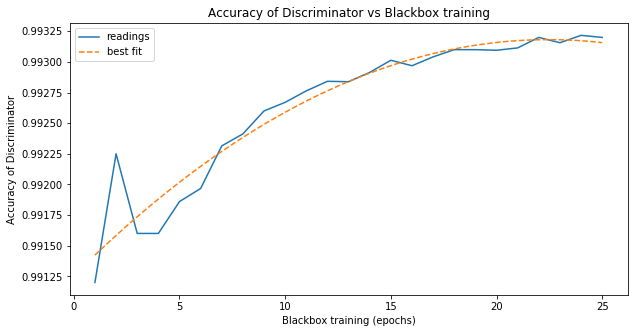

In [32]:
# Plot test losses wrt epochs trained

accs_test_c_np = np.array(accs_test_c)

# best fit line
xp = np.linspace(epoch_list[0], epoch_list[-1], 100)
z = np.polyfit(epoch_list, accs_test_c_np, 2)
p = np.poly1d(z)

plt.figure()
plt.title('Accuracy of Discriminator vs Blackbox training')
plt.plot(epoch_list, accs_test_c_np)
plt.plot(xp, p(xp), '--')
plt.xlabel('Blackbox training (epochs)')
plt.ylabel('Accuracy of Discriminator')
plt.legend(['readings', 'best fit'], loc='upper left')
plt.show()

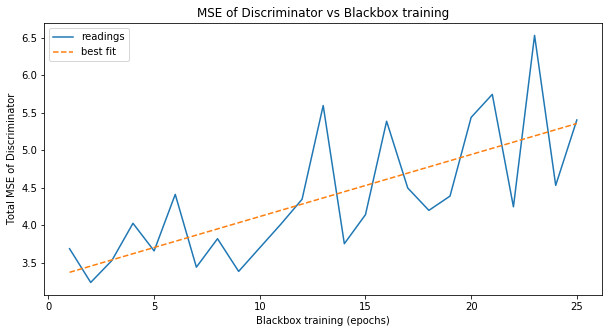

In [33]:
# Plot test losses wrt epochs trained

losses_test_np = np.array(losses_test)

# best fit line
xp = np.linspace(epoch_list[0], epoch_list[-1], 100)
z = np.polyfit(epoch_list, losses_test_np, 1)
p = np.poly1d(z)

plt.figure()
plt.title('MSE of Discriminator vs Blackbox training')
plt.plot(epoch_list, losses_test_np)
plt.plot(xp, p(xp), '--')
plt.xlabel('Blackbox training (epochs)')
plt.ylabel('Total MSE of Discriminator')
plt.legend(['readings', 'best fit'], loc='upper left')
plt.show()

In [25]:
# # Plot % difference in test accuracy wrt epochs trained

# accs_test_b_np = np.array(accs_test_b)
# accs_test_d_np = np.array(accs_test_d)

# accs_test_percent = (np.abs(accs_test_b_np - accs_test_d_np) / accs_test_b_np) * 100

# # best fit line
# xp = np.linspace(epoch_list[0], epoch_list[-1], 100)
# z = np.polyfit(epoch_list, accs_test_percent, 2)
# p = np.poly1d(z)

# plt.figure()
# plt.title('Percentage Error in Accuracy vs Blackbox training')
# plt.plot(epoch_list, accs_test_percent)
# plt.plot(xp, p(xp), '--')
# plt.xlabel('Blackbox training (epochs)')
# plt.ylabel('Percent error in Descriminator')
# plt.legend(['readings', 'best fit'], loc='upper left')
# plt.show()